**ANALYS OF RENTAL OFFERS IN TOULOUSE FOR 3 ROOMS APPARTMENT**

**Source of information** - leboncoin.fr - the most popular real estate site in France

**Purpose**: 
- estimate the possibility of renting an appatment/house in various neighborhoods according to the number of offers
- calculate the budget for rent
- estimate the average living area for 3 rooms appartments
- estimate the chance to rent an appartment directly from the owner

**Steps**:
- extracting information from leboncoin.fr
- creating attributes we interested in from raw data
- analyzing info

# Scraping info

Because leboncoin doesn't have free public API we use extension for Chrome - Web Scrapper. 
Here is link for understanding how it works https://www.dexxter.fr/articles/recuperer-automatiquement-donnees-le-bon-coin

We are interested in 3 rooms appartment for rent in Toulouse. So, for the begining we set search filters on the site: location - Toulouse (toute la ville),  number of rooms - 3 and price not more then 1500 euro and not less than 600 (to execlude appartments in very pityful state and joint apartment rental).
Then we create the sitemap with selectors. 
Finally, we extract the result, in a form of csv file with raw data containing information about price, area and geograpich location of the offers.
Because of the big number of relevant offers - trying to get more information from each offer card (opening link with offer) leads to captcha. Nevertheless, we still can scrape the main parametres of appartment.

Link to csv https://disk.yandex.ru/d/ksN-sMsJAbS8NA

# Creating attributes from raw data

In [1]:
#import libraries
import pandas as pd
import seaborn as sns

In [2]:
#reading scraped data from csv
df = pd.read_csv('leboncoin.csv')

Lets have a look what we have here

In [3]:
df.head()

,web-scraper-order,web-scraper-start-url,card,card-href
0,1652100656-2101,https://www.leboncoin.fr/recherche?category=10...,6847 €Appartement 3 pièces 72 m²ProToulouse 31...,https://www.leboncoin.fr/locations/2154299243.htm
1,1652100687-2310,https://www.leboncoin.fr/recherche?category=10...,9679 €Baisse de prixAppartement 3 pièces 64 m²...,https://www.leboncoin.fr/locations/2097322857.htm
2,1652100741-2723,https://www.leboncoin.fr/recherche?category=10...,9658 €Appartement 3 pièces 53 m²ProToulouse 31...,https://www.leboncoin.fr/locations/2154674795.htm
3,1652100666-2177,https://www.leboncoin.fr/recherche?category=10...,6780 €Appartement 3 pièces 57 m²ProToulouse 31...,https://www.leboncoin.fr/locations/2143021964.htm
4,1652100761-2858,https://www.leboncoin.fr/recherche?category=10...,3790 €Appartement T3 location meublé de qualit...,https://www.leboncoin.fr/locations/2158718045.htm


All necessary information is in the column `card` - we need to separate different parameters
We leave in df only columns card and card-href(for verification if we have some doubts)

In [4]:
df = df[['card', 'card-href']]

## Agency or owner

It is always better to get offer streight from owner than to have a deal with an agency

In [5]:
#in offers of agencies there is always "pro"
def get_who_rent(cell):
    if 'Pro' in cell or 'pro' in cell:
        return True
    else:
        return False  

In [6]:
df['is_agency'] = df['card'].apply(get_who_rent)

## Price

Here will be something quite tricky - I know that price for 3 rooms appartment normaly is between 600 and 1500 euro. By making comparision between prices on the site and what we have in dataframe we see that scraped information contains additional chiffres that we don't want
For example

In [7]:
df.iloc[1, :]

card         9679 €Baisse de prixAppartement 3 pièces 64 m²...
card-href    https://www.leboncoin.fr/locations/2097322857.htm
is_agency                                                 True
Name: 1, dtype: object

9679 = 679 euro

In [8]:
df.iloc[155, :]

card         5650 €APPARTEMENT T3 MEUBLE - 54 m²ProToulouse...
card-href    https://www.leboncoin.fr/locations/2141923246.htm
is_agency                                                 True
Name: 155, dtype: object

5650 = 650 euro

In [9]:
# cut wrong chiffres from the price
def get_price(cell):
    elem = cell.split('€')[0].replace('\xa0', '').replace(' ', '')
    if int(elem[len(elem)-3:]) < 600:
        price = int(elem[len(elem)-4:])
    else:
        price = int(elem[len(elem)-3:])
    return price    

In [10]:
df['price'] = df['card'].apply(get_price)

## Area

Not all offers have information about area (of course if you will open link for each offer you will find it. but leboncoin really doesn't like than somebody opens 1500 links)

In [11]:
def get_area(cell):
    lst = cell.split(' ')
    for i in range(len(lst)):
        if 'm²' in lst[i]:
            try:
                return float(lst[i-1])
            except:
                try:
                    return float(lst[i].replace('m²', ''))
                except:
                    pass

In [12]:
df['area'] = df['card'].apply(get_area)

## Location

Like in all cities in Toulouse there are 'good' and 'not so good' neighborhoods. Shortly about Toulouse

- 31000 - centre and hypercentre
- 31200 - 'not so good neighborhood'
- 31300 - nice area, not far from centre
- 31400 - as well good rayon, not very noisy and with good public transportation
- 31500 - quite far from centre, with more private houses than big residences
- 31100 - very very very far, not many appartments - mostly houses

In [13]:
def get_location(cell):
    lst = cell.split(' ')
    for elem in lst:
        if len(elem) > 4:
            try:
                elem = str(int(elem))
                if len(elem) == 5:
                    return elem
                else:
                    return elem[:5]
            except:
                continue


In [14]:
df['location'] = df['card'].apply(get_location)

## Price square meter for rent

In [15]:
df['price_m2'] = df['price']/df['area']

## Area category

Lets separate all appartment on big, average and small according to its area

In [16]:
def set_category(cell):
    if cell < 50:
        return "small area"
    elif cell >=50 and cell <=70:
        return "average area"
    else:
        return 'big area'
    

In [17]:
df['area_category'] = df['area'].apply(set_category)

## Duplicates

Agencies like to publishe the same offer everyday. Lets check how many duplicates in dataframe

In [18]:
df.duplicated(['price', 'area', 'location']).sum()

187

We gonna drop it

In [19]:
df = df.drop_duplicates(['price', 'area', 'location' ])

# Analysing information

In [20]:
len(df)

1313

So we have 1313 relevant offers - not bad

## Who rents?

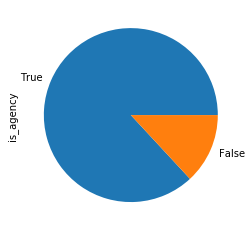

In [21]:
df['is_agency'].value_counts(normalize = True).plot.pie()

**Unfortunately, not big chance to rent appartment from an owner**

## Is it big?

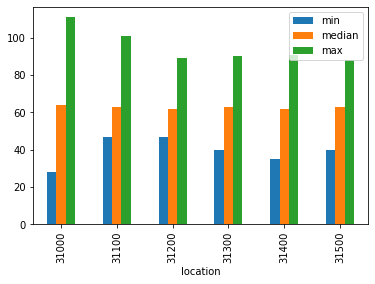

In [22]:
df.groupby('location')['area'].agg(['min', 'median', 'max']).plot.bar()

**Centre is amazing place with huge appartments (more than 100 m2) and tiny ones (28 м2, it really exists https://www.leboncoin.fr/locations/2100529933.htm ). For other rayons - there is not huge difference. Normaly area is about 62-65 м2 and doesn't depend on location**

## How much does it coast?

It is obvious that the price depend on the location, the public transportation and the "reputation" of rayon.

In [23]:
df.groupby('location')['price'].agg(['min', 'median', 'max'])

,min,median,max
location,,,
31000,600,911.0,1500
31100,616,717.0,1170
31200,601,699.0,1180
31300,630,763.0,1500
31400,601,765.5,1400
31500,600,750.0,1306


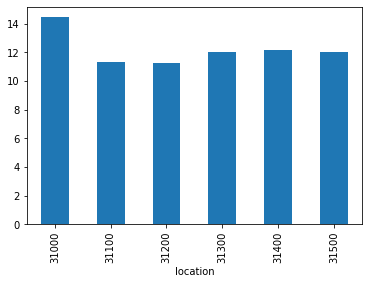

In [24]:
df.groupby('location')['price_m2'].median().plot.bar()

**As expected, centre is the most expensive. And rayon with not good criminal enviroment is the cheapest as well as rayon located far from centre**

## Where?

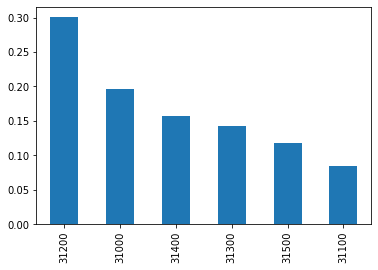

In [25]:
df['location'].value_counts(normalize=True).plot.bar()

**More offers are in bad rayon - people prefer pay more but have better social environement - so offers like these stay on the site for long time. The least offers - in suburb, just because there are not many appartments - people have their own houses**

## If price really correlates with area?

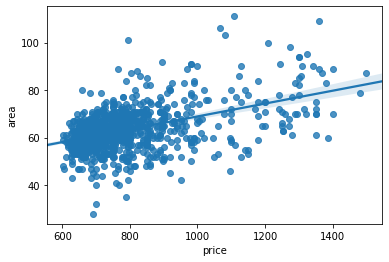

In [26]:
sns.regplot(x='price', y='area', data=df) 

In [27]:
df[['price', 'area']].corr()

,price,area
price,1.000000,0.475997
area,0.475997,1.000000


**Correlation is moderate (chaddock scale ). Area has impact on the price mostly for big appartments. For price 600-800 euro you have all type of appartments**

## If you want bigger appartment

In [28]:
df.groupby('area_category')['price'].median()

area_category
average area    725
big area        850
small area      750
Name: price, dtype: int64

**For getting big appartment you have to pay 130 euro more than for average one.** 

In [29]:
df['area_category'].value_counts(normalize = True)

average area    0.667174
big area        0.304646
small area      0.028180
Name: area_category, dtype: float64

**Most of offers - appartment 50-70 м2. Appartments with area less than 50 m2 - very rare**

# Conclusion

- there are 30% of offers in not good neighborhood (31200) 
- budget for rent - 700-800 euro (and around 900-1000 if you wanna live in the centre)
- average area of the appartment - 60-65 м2 
- wanna appartment more than 70 m2 - add to budget 100-150 euro
- more than 80 % - offers from agencies